In [ ]:
import pandas as pd

# Load the cleaned and merged dataset
df = pd.read_csv("../data/cleaned_avian_with_weather.csv")

# Quick inspection
print(df.info())
print(df.head())


In [80]:
# Define risk levels based on case count
def classify_risk(case_count):
    if case_count < 3:
        return "Low"
    elif case_count <= 5:
        return "Moderate"
    else:
        return "High"

df['Risk_Level'] = df['Case count'].apply(classify_risk)


In [81]:
print("Before encoding:")
print(df['Risk_Level'].value_counts())
print(df['Risk_Level'].unique())


Before encoding:
Low         192
Moderate     54
High         28
Name: Risk_Level, dtype: int64
['Moderate' 'High' 'Low']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Drop unwanted columns
df = df.drop(['Month', 'Diagnoses', 'Date'], axis=1)

# One-hot encode Region and Season
df = pd.get_dummies(df, columns=['Region', 'Season'], drop_first=True)

# Label encode target variable Risk_Level
le = LabelEncoder()
df['Risk_Level'] = le.fit_transform(df['Risk_Level'])

# Now your df is ready for modeling
print(df.head())


In [84]:
X = df.drop('Risk_Level', axis=1)  # Features
y = df['Risk_Level']               # Target


In [85]:
print(df['Risk_Level'].value_counts())

1    192
2     54
0     28
Name: Risk_Level, dtype: int64


In [86]:
numeric_features = ['Year', 'Case count', 'Month_Num', 'Last_Month_Case_Count', 'Last_Year_Same_Month', 'Avg_Temp_C']


In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42, stratify=y
)


In [88]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Identify the categorical features (all except numeric + target)
categorical_features = [col for col in X_train.columns if col not in numeric_features]

# Column transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    # Categorical one-hot features are already 0/1 encoded, so we pass them through
    ('cat', 'passthrough', categorical_features)
])


In [90]:
# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Random Forest pipeline
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])


In [91]:
for name, pipeline in [('Logistic Regression', pipeline_lr), ('Random Forest', pipeline_rf)]:
    print(f"\n{name}")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



Logistic Regression
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.93      1.00      0.96        67
           2       0.93      0.74      0.82        19

    accuracy                           0.94        96
   macro avg       0.95      0.88      0.91        96
weighted avg       0.94      0.94      0.93        96

Confusion Matrix:
[[ 9  0  1]
 [ 0 67  0]
 [ 0  5 14]]

Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.97      1.00      0.99        67
           2       1.00      0.89      0.94        19

    accuracy                           0.98        96
   macro avg       0.99      0.96      0.98        96
weighted avg       0.98      0.98      0.98        96

Confusion Matrix:
[[10  0  0]
 [ 0 67  0]
 [ 0  2 17]]


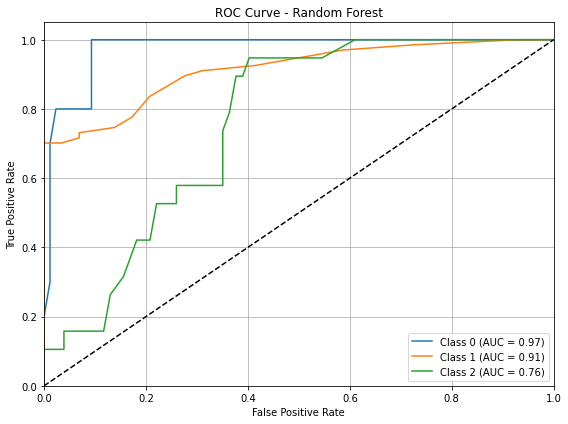

AUC for class 0: 0.9744
AUC for class 1: 0.9120
AUC for class 2: 0.7591


In [93]:


# Predict probabilities
y_score = rf.predict_proba(X_test)

# Binarize target for ROC curve
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

# Print AUC scores
for i in range(len(classes)):
    print(f"AUC for class {classes[i]}: {roc_auc[i]:.4f}")


In [42]:
pip install autogluon --user


  Using cached autogluon-1.3.0-py3-none-any.whl (9.8 kB)
  Using cached autogluon.core-1.3.0-py3-none-any.whl (222 kB)
  Using cached autogluon.features-1.3.0-py3-none-any.whl (64 kB)
  Using cached autogluon.timeseries-1.3.0-py3-none-any.whl (181 kB)
  Using cached autogluon.tabular-1.3.0-py3-none-any.whl (382 kB)
  Using cached autogluon.multimodal-1.3.0-py3-none-any.whl (454 kB)
  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached boto3-1.38.19-py3-none-any.whl (139 kB)
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl (11.6 MB)
  Using cached scikit_learn-1.6.1-cp39-cp39-win_amd64.whl (11.2 MB)
  Using cached autogluon.common-1.3.0-py3-none-any.whl (69 kB)
  Using cached matplotlib-3.9.4-cp39-cp39-win_amd64.whl (7.8 MB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
  Using cached ray-2.44.1-cp39-cp39-win_amd64.whl (25.7 MB)
  Using cached accelerate-1.7.0-py3-none-any.whl (362 kB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached nlpaug-

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.10.1 requires ruamel-yaml, which is not installed.
cookiecutter 1.7.2 requires Jinja2<3.0.0, but you have jinja2 3.1.6 which is incompatible.
cookiecutter 1.7.2 requires MarkupSafe<2.0.0, but you have markupsafe 3.0.2 which is incompatible.



  Using cached fastcore-1.7.29-py3-none-any.whl (84 kB)
  Using cached fastdownload-0.0.7-py3-none-any.whl (12 kB)
  Using cached adagio-0.2.6-py3-none-any.whl (19 kB)
  Using cached triad-0.9.8-py3-none-any.whl (62 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)
  Using cached jsonschema_specifications-2025.4.1-py3-none-any.whl (18 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl (28 kB)
  Using cached contourpy-1.3.0-cp39-cp39-win_amd64.whl (211 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
  Using cached window_ops-0.0.15-py3-none-any.whl (15 kB)
  Using cached optuna-4.3.0-py3-none-any.whl (386 kB)
  Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached model_index-0.1.11-py3-none-any.whl (34 kB)
  Using cached opendatalab-0.0.10-py3-none-any.whl (29 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached packaging-24.2-py3-none-any.whl (65

In [92]:
from autogluon.tabular import TabularPredictor

# Step 1: Train
predictor = TabularPredictor(label='Risk_Level', eval_metric='f1_weighted').fit(train_data)

# Step 2: View all models
leaderboard_df = predictor.leaderboard(test_data, silent=False)

# Step 3: Evaluate top N models on multiple metrics
from sklearn.metrics import classification_report

# Predict with top 5 models (example)
top_models = leaderboard_df['model'].head(5).tolist()

for model in top_models:
    y_pred = predictor.predict(test_data.drop(columns=['Risk_Level']), model=model)
    print(f"\n===== Evaluation for Model: {model} =====")
    print(classification_report(test_data['Risk_Level'], y_pred, target_names=le.classes_))


No path specified. Models will be saved in: "AutogluonModels\ag-20250521_012818"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.9.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
Memory Avail:       1.88 GB / 11.85 GB (15.8%)
Disk Space Avail:   17.91 GB / 222.84 GB (8.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : 

                  model  score_test  score_val  eval_metric  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0            LightGBMXT    1.000000   1.000000  f1_weighted        0.050862       0.002981    1.270089                 0.050862                0.002981           1.270089            1       True          4
1              LightGBM    1.000000   1.000000  f1_weighted        0.056743       0.007140    0.964393                 0.056743                0.007140           0.964393            1       True          5
2         LightGBMLarge    1.000000   1.000000  f1_weighted        0.078386       0.004778    1.713890                 0.078386                0.004778           1.713890            1       True         12
3               XGBoost    1.000000   1.000000  f1_weighted        0.135317       0.011081    1.337050                 0.135317                0.011081           1.337050      

In [74]:
# Calculate correlation matrix
corr = df.corr()

# Extract correlation with 'Risk_Level' column and sort descending by absolute value
corr_with_target = corr['Risk_Level'].drop('Risk_Level').sort_values(key=abs, ascending=False)

print(corr_with_target)


Case count                        -0.521803
Last_Month_Case_Count             -0.156236
Year                               0.114783
Region_East of England             0.093629
Region_South West                 -0.088749
Region_Scotland                   -0.080871
Region_South East                  0.053773
Region_Yorkshire and The Humber    0.039427
Region_North East                  0.034494
Region_London                      0.024210
Region_Wales                      -0.022726
Month_Num                         -0.018427
Region_North West                  0.017097
Avg_Temp_C                        -0.016776
Region_West Midlands              -0.016684
Season_Summer                      0.013699
Season_Spring                     -0.011740
Season_Winter                      0.005901
Last_Year_Same_Month               0.003691
Name: Risk_Level, dtype: float64


In [99]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# === Load your dataset ===
df = pd.read_csv("../data/cleaned_avian_with_weather.csv")  # Replace with your file path
target_column = 'Case count'

y = df[target_column]
X = df.drop(columns=[target_column])

# === Define feature types ===
numeric_features = ['Year', 'Month_Num', 'Last_Month_Case_Count', 'Last_Year_Same_Month', 'Avg_Temp_C']
categorical_features = [col for col in X.columns if col not in numeric_features]

# === Split data ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=42
)

# === Preprocessing: scale numeric, encode categorical ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# === Pipeline ===
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# === Train ===
pipeline.fit(X_train, y_train)

# === Predict & Evaluate ===
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")


Mean Absolute Error (MAE): 1.303
Root Mean Squared Error (RMSE): 1.954
R² Score: 0.073


In [100]:

# y_test and y_pred should be in original (inverse-transformed) scale
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Approximate Accuracy: {accuracy:.2f}%")


Mean Absolute Percentage Error (MAPE): 55.98%
Approximate Accuracy: 44.02%
